In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt    
import matplotlib.image as mpimg
import time
import pickle
import os.path
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split
from skimage.feature import hog
from scipy.ndimage.measurements import label
from scipy.ndimage import label, generate_binary_structure

%matplotlib inline

class Vehicle():    
    def __init__(self, color_space ='YCrCb',
                 spatial_size = (32, 32),hist_bins = 32,
                 orient = 9, pix_per_cell = 8, cell_per_block = 2,
                 hog_channel = "ALL", spatial_feat = True,
                 hog_feat = True, hist_feat = True):
        
        # Global Variables
        self.color_space = color_space
        self.spatial_size = spatial_size
        self.hist_bins = hist_bins
        self.orient = orient
        self.pix_per_cell = pix_per_cell
        self.cell_per_block = cell_per_block
        self.hog_channel = hog_channel # Can be 0, 1, 2, or "ALL"
        self.spatial_feat = spatial_feat
        self.hog_feat = hog_feat
        self.hist_feat = hist_feat
        self.heatmaps = []        
        self.count=-1 #Variable for frame skip
        self.structure = generate_binary_structure(2,2) #structure for label parameter
        
        if os.path.isfile('svc.pickle'):
            print("Using existing SVC..")            
            with open('svc.pickle', 'rb') as handle:
                data = pickle.load(handle)                      
                self.svc = data['svc']
                self.X_scaler = data['X_scaler']
        else:
            self.training()
                
    
    #Training the features from the cars and non cars images
    def training(self):
        
        #Load training images
        print("Loading images..")
        cars = glob.glob('vehicles/**/*.png')
        notcars = glob.glob('non-vehicles/**/*.png')
        data_info = self.data_look(cars,notcars)
        print('There are', 
              data_info["n_cars"], ' cars and', 
              data_info["n_notcars"], ' non-cars images')
        print('Each size: ',data_info["image_shape"], ' and data type:', 
              data_info["data_type"])
        
        #Extract features from the images
        print("\nExtracting features from training images..")
        t=time.time()
        if os.path.isfile('car_features.pickle'):
            print("Using existing data..")
            with open('car_features.pickle', 'rb') as handle:
                data = pickle.load(handle)
                car_features, notcar_features = data['car'], data['notcar']
        else:
            print("No existing data, Make new features..")
            car_features = self.extract_features(cars, color_space=self.color_space, 
                                    spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                    orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                    cell_per_block=self.cell_per_block, 
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                                    hist_feat=self.hist_feat, hog_feat=self.hog_feat)
            notcar_features = self.extract_features(cars, color_space=self.color_space, 
                                    spatial_size=self.spatial_size, hist_bins=self.hist_bins, 
                                    orient=self.orient, pix_per_cell=self.pix_per_cell, 
                                    cell_per_block=self.cell_per_block, 
                                    hog_channel=self.hog_channel, spatial_feat=self.spatial_feat, 
                                    hist_feat=self.hist_feat, hog_feat=self.hog_feat)
            data = {'car':car_features,'notcar':notcar_features}
            with open('car_features.pickle', 'wb') as handle:
                pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to extract features...')

        #Normalizing training images
        print("\nNormalizing..") 
        t=time.time() 
        X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
        # Fit a per-column scaler
        self.X_scaler = StandardScaler().fit(X)
        # Apply the scaler to X
        scaled_X = self.X_scaler.transform(X)
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        print("Shape of scaled_X :",scaled_X.shape)
        print("Shape of Y : ",y.shape)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to Normalizing...')
        
        
        # Split up data into randomized training and test sets
        print("\nSplit training set, and testing set..")
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(
            scaled_X, y, test_size=0.2, random_state=rand_state)
        print('Using:',self.orient,'orientations',self.pix_per_cell,
              'pixels per cell and', self.cell_per_block,'cells per block, ')
        print('Feature vector length:', len(X_train[0]))
        print("X_train: ",X_train.shape)
        print("y_train: ",y_train.shape)
        print("X_test: ",X_test.shape)
        print("y_test: ",y_test.shape)

        # Use a linear SVC as a classifier
        print("\nTraining..")
        t=time.time()        
        self.svc = LinearSVC()        
        self.svc.fit(X_train, y_train)
        t2 = time.time()
        print(round(t2-t, 2), 'Seconds to train SVC...')
        # Check the score of the SVC
        print('Test Accuracy of SVC = ', round(self.svc.score(X_test, y_test), 4))
        
        with open('svc.pickle', 'wb') as handle:
            data['svc']=self.svc
            data['X_scaler']=self.X_scaler            
            pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)
            print("Saved svc.pickle")

        
    #Characteristics of the car / not-car dataset 
    def data_look(self, car_list, notcar_list):
        data_dict = {}
        # Define a key in data_dict "n_cars" and store the number of car images
        data_dict["n_cars"] = len(car_list)
        # Define a key "n_notcars" and store the number of notcar images
        data_dict["n_notcars"] = len(notcar_list)
        # Read in a test image, either car or notcar
        example_img = mpimg.imread(car_list[0])
        # Define a key "image_shape" and store the test image shape 3-tuple
        data_dict["image_shape"] = example_img.shape
        # Define a key "data_type" and store the data type of the test image.
        data_dict["data_type"] = example_img.dtype
        data_dict["max_value"] = np.max(example_img)
        data_dict["min_value"] = np.min(example_img)
        # Return data_dict
        return data_dict

    
    #Convert RGB color to..
    def convert_color(self, img, conv='YCrCb'):
        if conv == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif conv == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif conv == 'HSV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif conv == 'HLS':
            return cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif conv == 'YUV':
            return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

    
    def get_hog_features(self, img, orient, pix_per_cell, cell_per_block, 
                            vis=False, feature_vec=True):
        # Call with two outputs if vis==True
        if vis == True:
            features, hog_image = hog(img, orientations=orient, 
                                      pixels_per_cell=(pix_per_cell, pix_per_cell),
                                      cells_per_block=(cell_per_block, cell_per_block), 
                                      transform_sqrt=False, 
                                      visualise=vis, feature_vector=feature_vec)
            return features, hog_image
        # Otherwise call with one output
        else:      
            features = hog(img, orientations=orient, 
                           pixels_per_cell=(pix_per_cell, pix_per_cell),
                           cells_per_block=(cell_per_block, cell_per_block), 
                           transform_sqrt=False, 
                           visualise=vis, feature_vector=feature_vec)
            return features
        
    def bin_spatial(self, img, size=(32, 32)):
        color1 = cv2.resize(img[:,:,0], size).ravel()
        color2 = cv2.resize(img[:,:,1], size).ravel()
        color3 = cv2.resize(img[:,:,2], size).ravel()
        return np.hstack((color1, color2, color3))

    def color_hist(self, img, nbins=32):    #bins_range=(0, 256)
        # Compute the histogram of the color channels separately
        channel1_hist = np.histogram(img[:,:,0], bins=nbins)
        channel2_hist = np.histogram(img[:,:,1], bins=nbins)
        channel3_hist = np.histogram(img[:,:,2], bins=nbins)
        # Concatenate the histograms into a single feature vector
        hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
        # Return the individual histograms, bin_centers and feature vector
        return hist_features        
        
    def extract_features(self, imgs, color_space='RGB', spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=0,
                            spatial_feat=True, hist_feat=True, hog_feat=True):
        
        # Create a list to append feature vectors to
        features = []
        # Iterate through the list of images
        print("Images is converted to ",color_space)
        for file in imgs:
            file_features = []
            # Read in each one by one
            image = mpimg.imread(file)
            # apply color conversion if other than 'RGB'        
            if color_space != 'RGB':
                feature_image = self.convert_color(image,conv=color_space)                
            else: feature_image = np.copy(image)             

            if spatial_feat == True:
                spatial_features = self.bin_spatial(feature_image, size=self.spatial_size)
                file_features.append(spatial_features)
            if hist_feat == True:
                # Apply color_hist()
                hist_features = self.color_hist(feature_image, nbins=self.hist_bins)
                file_features.append(hist_features)
            if hog_feat == True:
            # Call get_hog_features() with vis=False, feature_vec=True
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(feature_image.shape[2]):
                        hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                            self.orient, self.pix_per_cell, self.cell_per_block, 
                                            vis=False, feature_vec=True))
                    hog_features = np.ravel(hog_features)        
                else:
                    hog_features = self.get_hog_features(feature_image[:,:,hog_channel], self.orient, 
                                self.pix_per_cell, self.cell_per_block, vis=False, feature_vec=True)
                # Append the new feature vector to the features list
                file_features.append(hog_features)
            features.append(np.concatenate(file_features))
        # Return list of feature vectors
        return features

    # Extract features using hog sub-sampling and make predictions
    def find_cars(self, img, box_list,
                  ystart, ystop, xstart, xstop,
                  scale, svc, X_scaler,
                  orient, pix_per_cell, cell_per_block,
                  spatial_size, hist_bins):
        
        draw_img = np.copy(img)
        img = img.astype(np.float32)/255    
        img_tosearch = img[ystart:ystop,xstart:xstop,:]
        ctrans_tosearch = self.convert_color(img_tosearch, conv='YCrCb')
        
        if scale != 1:
            imshape = ctrans_tosearch.shape
            ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]

        # Define blocks and steps as above
        nxblocks = (ch1.shape[1] // pix_per_cell)-1
        nyblocks = (ch1.shape[0] // pix_per_cell)-1 
        nfeat_per_block = orient*cell_per_block**2
        
        # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
        window = 64
        nblocks_per_window = (window // pix_per_cell)-1 
        cells_per_step = 2  # Instead of overlap, define how many cells to step
        nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
        nysteps = (nyblocks - nblocks_per_window) // cells_per_step

        # Compute individual channel HOG features for the entire image
        hog1 = self.get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = self.get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = self.get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)

        for xb in range(nxsteps):
            for yb in range(nysteps):
                ypos = yb*cells_per_step
                xpos = xb*cells_per_step
                # Extract HOG for this patch
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

                xleft = xpos*pix_per_cell
                ytop = ypos*pix_per_cell

                # Extract the image patch
                subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

                # Get color features
                spatial_features = self.bin_spatial(subimg, size=spatial_size)
                hist_features = self.color_hist(subimg, nbins=hist_bins)

                # Scale features and make a prediction
                test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))                    
                test_prediction = svc.predict(test_features)
                if scale==1:
                    c = (255,0,0)
                elif scale==1.5:
                    c = (0,255,0)
                else:
                    c = (0,0,255)
                if test_prediction == 1: #or test_prediction ==0
                    xbox_left = np.int(xleft*scale)
                    ytop_draw = np.int(ytop*scale)
                    win_draw = np.int(window*scale)
                    box_list.append(((xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart)))                
                    cv2.rectangle(draw_img,(xbox_left+xstart, ytop_draw+ystart),(xbox_left+win_draw+xstart,ytop_draw+win_draw+ystart),c,6)                         
       
        return draw_img, box_list
    
    # Return updated heatmap
    def add_heat(self, heatmap, bbox_list):
        # Iterate through list of bboxes
        for box in bbox_list:
            # Add += 1 for all pixels inside each bbox
            # Assuming each "box" takes the form ((x1, y1), (x2, y2))
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
        return heatmap

    # Return thresholded map
    def apply_threshold(self, heatmap, threshold):
        # Zero out pixels below the threshold
        heatmap[heatmap <= threshold] = 0        
        return heatmap

    def draw_labeled_bboxes(self, img, labels):
        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            # Find pixels with each car_number label value
            nonzero = (labels[0] == car_number).nonzero()
            # Identify x and y values of those pixels
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            # Define a bounding box based on min/max x and y
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))        
            # Draw the box on the image
            cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
            # Input Text on top of the box
            cv2.rectangle(img, (bbox[0][0],bbox[0][1]-40), (bbox[0][0]+75,bbox[0][1]), (0,0,255), -1)
            cv2.putText(img,"Car",(bbox[0][0]+5,bbox[0][1]-12), cv2.FONT_HERSHEY_SIMPLEX, 1.2,(255,255,255),2)        
        return img

    def vehicle_start(self, img):
        #Detect every 5 frames
        self.count +=1                
        if self.count%5==0:             
            self.count=0
            heat = np.zeros_like(img[:,:,0]).astype(np.float)                
            xstart, xstop = 400,None        
            box_list=[]
            scalelist = [1,1.5,2]    
            draw_img = np.copy(img)
            for scale in scalelist:
                if(scale==1):            
                    ystart,ystop = 400,500                 
                elif(scale==1.5):
                    ystart,ystop = 400,630                
                else:
                    ystart,ystop = 400,700                                
                draw_img, box_list = self.find_cars(draw_img, box_list, ystart, ystop, xstart, xstop, scale, 
                                          self.svc, self.X_scaler, self.orient, 
                                          self.pix_per_cell, self.cell_per_block, 
                                          self.spatial_size, self.hist_bins)        
            # Add heat to each box in box list
            heat = self.add_heat(heat,box_list)            

            # Sum up heatmap list
            self.heatmaps.append(heat)
            
            
            # Keep heatmap list with last 10 detections            
            if len(self.heatmaps)>10 :                                
                self.heatmaps.pop(0)
            mean_heatmap = np.mean(self.heatmaps,axis=0)            
            heat = self.apply_threshold(mean_heatmap,1)

            # Visualize the heatmap when displaying    
            heatmap = np.clip(heat, 0, 255)

            # Find final boxes from heatmap using label function             
            self.labels = label(heatmap, self.structure)
            img = self.draw_labeled_bboxes(img, self.labels)            
            return img 
        else:
            img = self.draw_labeled_bboxes(img, self.labels)            
            return img

/home/hyukpyohong/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [51]:
from moviepy.editor import VideoFileClip
#Make test images which subsequent frames
clip = VideoFileClip("test_video.mp4")
frames = int(clip.fps)
print(frames,"fps")
for num in range(0,7):
    clip.save_frame("test_images/Chal_frame"+str(num)+".jpg", t=0+num*(5/frames))    

25 fps


Using existing SVC..
Test Image size:  (720, 1280, 3)
Test Image data type:  uint8
Test Image[0] value range between  0  and  255


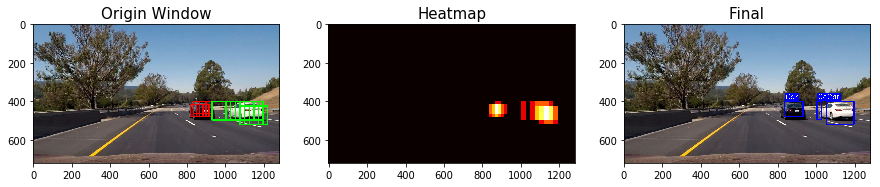

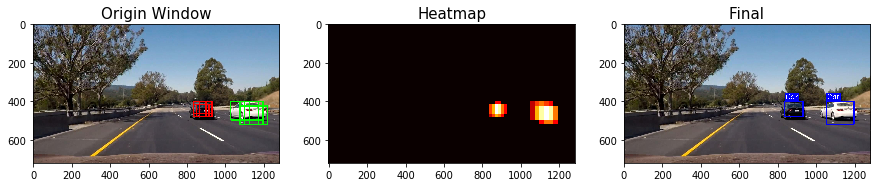

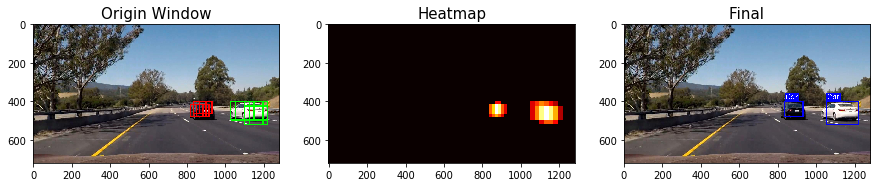

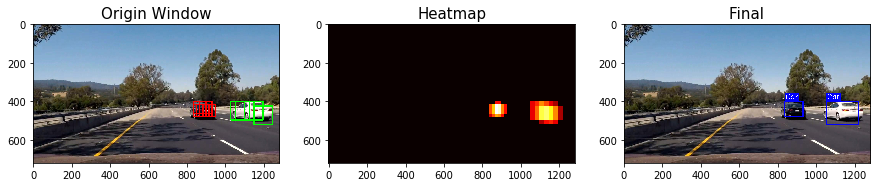

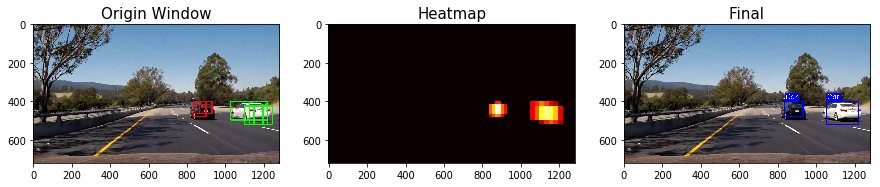

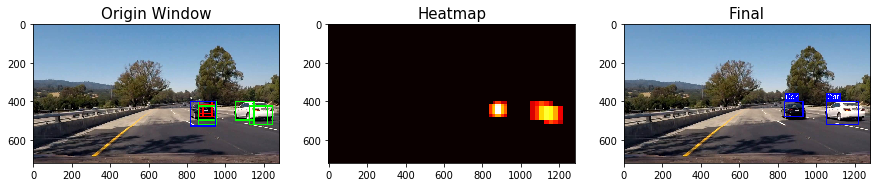

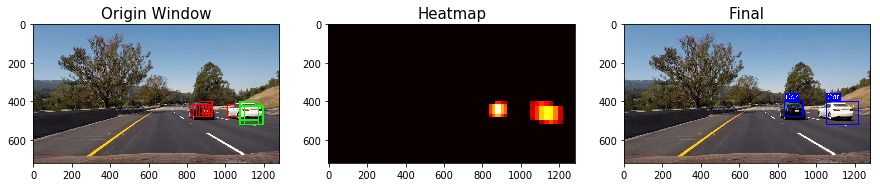

In [56]:
#Test with subsequent images
obj = Vehicle()

#test_img = glob.glob('test_images/frame*.jpg')
test_img = glob.glob('test_images/Chal_frame*.jpg')
data_info = obj.data_look(test_img,[])
print('Test Image size: ',data_info["image_shape"])
print('Test Image data type: ',data_info["data_type"])
print('Test Image[0] value range between ',data_info["min_value"],' and ',data_info["max_value"])

for img in test_img: 
    img = mpimg.imread(img)
    draw_img, heatmap, img = obj.vehicle_start(img)    
     
    fig, axes = plt.subplots(1,3, figsize=(15,15))   
    
    for idx,ax in enumerate(axes.flat):  
        if idx==0:
            ax.set_title('Origin Window', fontsize=15)
            ax.imshow(draw_img)
        if idx==1:
            ax.set_title('Heatmap', fontsize=15)
            ax.imshow(heatmap,cmap='hot')
        if idx==2:
            ax.set_title('Final', fontsize=15)
            ax.imshow(img)


In [46]:
from moviepy.editor import VideoFileClip

obj = Vehicle()
clip = VideoFileClip("test_video.mp4")
output ="test_video_output.mp4"
output_clip = clip.fl_image(obj.vehicle_start)
%time output_clip.write_videofile(output, audio=False)

Using existing SVC..
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|█████████▋| 38/39 [00:33<00:00,  1.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 34.4 s, sys: 208 ms, total: 34.7 s
Wall time: 36.2 s


In [194]:
from moviepy.editor import VideoFileClip

obj = Vehicle()
clip = VideoFileClip("project_video.mp4")
output ="project_video_output.mp4"
output_clip = clip.fl_image(obj.vehicle_start)
%time output_clip.write_videofile(output, audio=False)

Using existing SVC..
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1260/1261 [04:31<00:00,  3.54it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 4min 16s, sys: 2.69 s, total: 4min 19s
Wall time: 4min 33s
